In [1]:
import pandas as pd
import glob
import pyspark
import os

Set up pyspark environment

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

25/06/20 10:02:21 WARN Utils: Your hostname, Baohongs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.232.169.110 instead (on interface en0)
25/06/20 10:02:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/20 10:02:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Read model prediction files

In [27]:
os.getcwd()

'/Users/baohongzhuang/Desktop/03 MLE/MLE_grp10/scripts'

In [1]:
#Import predictions
snapshotdate = '2017-01-01'
snapshotdate_str = snapshotdate.replace('-', '_')
file_name = 'reg_2017_12_04_predictions_' + snapshotdate_str + '.parquet'
model_pred_loc = "datamart/gold/model_predictions/reg_2017_12_04/"
file_path = os.path.join(model_pred_loc, file_name)
#files_list = glob.glob(os.path.join(model_pred_loc, '*.parquet'))
model_pred_list = spark.read.option("header", "true").parquet(file_path)
print("row_count for features:",model_pred_list.count(),"\n")

model_pred = model_pred_list.toPandas()

model_pred

NameError: name 'os' is not defined

In [135]:
#Import the ground truths
ground_truth_loc =  "datamart/gold/label_store/"
files_list = glob.glob(os.path.join(ground_truth_loc, snapshotdate_str+'*.parquet'))
ground_truth_list = spark.read.option("header", "true").parquet(*files_list)
print("row_count for label:",ground_truth_list.count(),"\n")
ground_truth = ground_truth_list.toPandas()

ground_truth_list.count()

row_count for label: 0 



0

In [136]:
from sklearn.metrics import fbeta_score

f1_5_score = 0 
if ground_truth_list.count() == 0:
    df_results = pd.DataFrame([[snapshotdate, f1_5_score]], columns=['snapshot_date', 'f1_5_score'])
else:
    final_df = (
        ground_truth.merge(model_pred, how='left', on='order_id')
        [['order_id','model_predictions','miss_delivery_sla','model_name','snapshot_date_y']]  # select columns
        .rename(columns={'miss_delivery_sla': 'groud_truth'})  # rename
    )
    # Drop NaNs and ensure integer types
    filtered_eval = final_df.dropna(subset=["groud_truth", "model_predictions"])
    y_true = filtered_eval["groud_truth"].astype(int)
    y_pred = filtered_eval["model_predictions"].astype(int)

    # Compute F1.5 score
    f1_5_score = fbeta_score(y_true, y_pred, beta=1.5)
    print(f"F1.5-score: {f1_5_score:.4f}")
    df_results = pd.DataFrame([[snapshotdate, f1_5_score]], columns=['snapshot_date', 'f1_5_score'])

#df_results[df_results['snapshot_date'] == date_str]['f1_5_score']

df_results

,snapshot_date,f1_5_score
0,2017-01-01,0


In [143]:
import os
import glob
import pyspark
import pyspark.sql.functions as F
from tqdm import tqdm
from pyspark.sql.functions import col, expr, date_add, when,to_date

# --- save model inference to datamart gold table ---
gold_directory = f"datamart/gold/model_monitoring/reg/"

if not os.path.exists(gold_directory):
    os.makedirs(gold_directory)

# save gold table
partition_name = snapshotdate_str+'.parquet'
filepath = gold_directory + partition_name
spark.createDataFrame(df_results).write.mode("overwrite").parquet(filepath)

print(df_results)
print(filepath)

  snapshot_date  f1_5_score
0    2017-01-01           0
datamart/gold/model_monitoring/reg/2017_01_01.parquet


In [145]:
path = 'datamart/gold/model_monitoring/reg'
filepath = glob.glob(os.path.join(path, '*.parquet'))

# Unpack the list of files
model_monitoring=spark.read.option("header", "true").parquet(*filepath)
# Convert to Pandas for inspection
model_monitoring_test = model_monitoring.toPandas()
model_monitoring_test.sort_values('snapshot_date')

,snapshot_date,f1_5_score
0,2017-01-01,0.000000
1,2017-11-28,0.768227


In [ ]:
# Convert snapshot_date to datetime if it's not already
model_monitoring['snapshot_date'] = pd.to_datetime(model_monitoring['snapshot_date'])
model_monitoring['snapshot_date'] = model_monitoring['snapshot_date'].str.replace('_', '-')

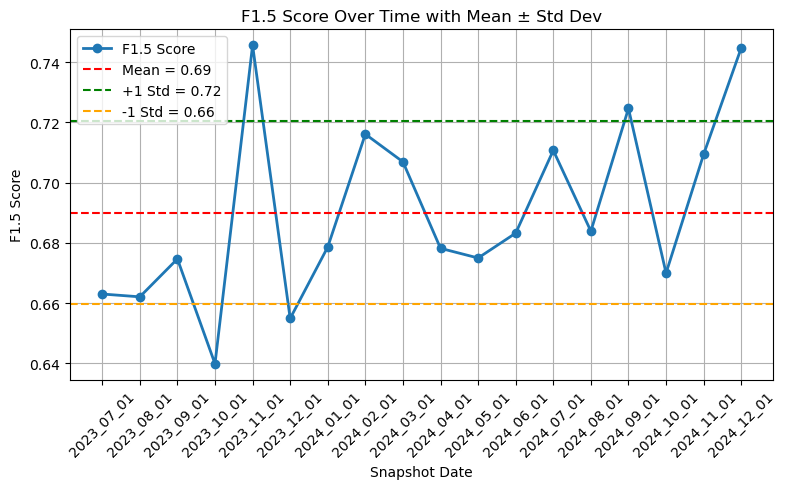

In [30]:
import matplotlib.pyplot as plt

# Sort by snapshot date
model_monitoring = model_monitoring.sort_values('snapshot_date')

# Calculate mean and standard deviation
avg_f1_5 = model_monitoring['f1_5_score'].mean()
std_f1_5 = model_monitoring['f1_5_score'].std()
upper_bound = avg_f1_5 + std_f1_5
lower_bound = avg_f1_5 - std_f1_5

# Plot
plt.figure(figsize=(8, 5))
plt.plot(model_monitoring['snapshot_date'], model_monitoring['f1_5_score'], marker='o', linewidth=2, label='F1.5 Score')

# Mean line
plt.axhline(y=avg_f1_5, color='red', linestyle='--', label=f'Mean = {avg_f1_5:.2f}')

# Std deviation bounds
plt.axhline(y=upper_bound, color='green', linestyle='--', label=f'+1 Std = {upper_bound:.2f}')
plt.axhline(y=lower_bound, color='orange', linestyle='--', label=f'-1 Std = {lower_bound:.2f}')

# Labels and formatting
plt.xlabel('Snapshot Date')
plt.ylabel('F1.5 Score')
plt.title('F1.5 Score Over Time with Mean ± Std Dev')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
baseline_f1_5 = model_monitoring['f1_5_score'].mean()
std_f1_5 = model_monitoring['f1_5_score'].std()

Investigate

In [33]:
os.getcwd()

'/Users/baohongzhuang/Desktop/03 MLE/mle_a2'

In [7]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df

In [17]:
features_store_sdf = read_gold_table('feature_store', 'scripts/datamart/gold', spark)
label_store_sdf = read_gold_table('label_store', 'scripts/datamart/gold', spark)

feature_store = features_store_sdf.toPandas()
feature_store['snapshot_date'] = pd.to_datetime(feature_store['snapshot_date'])


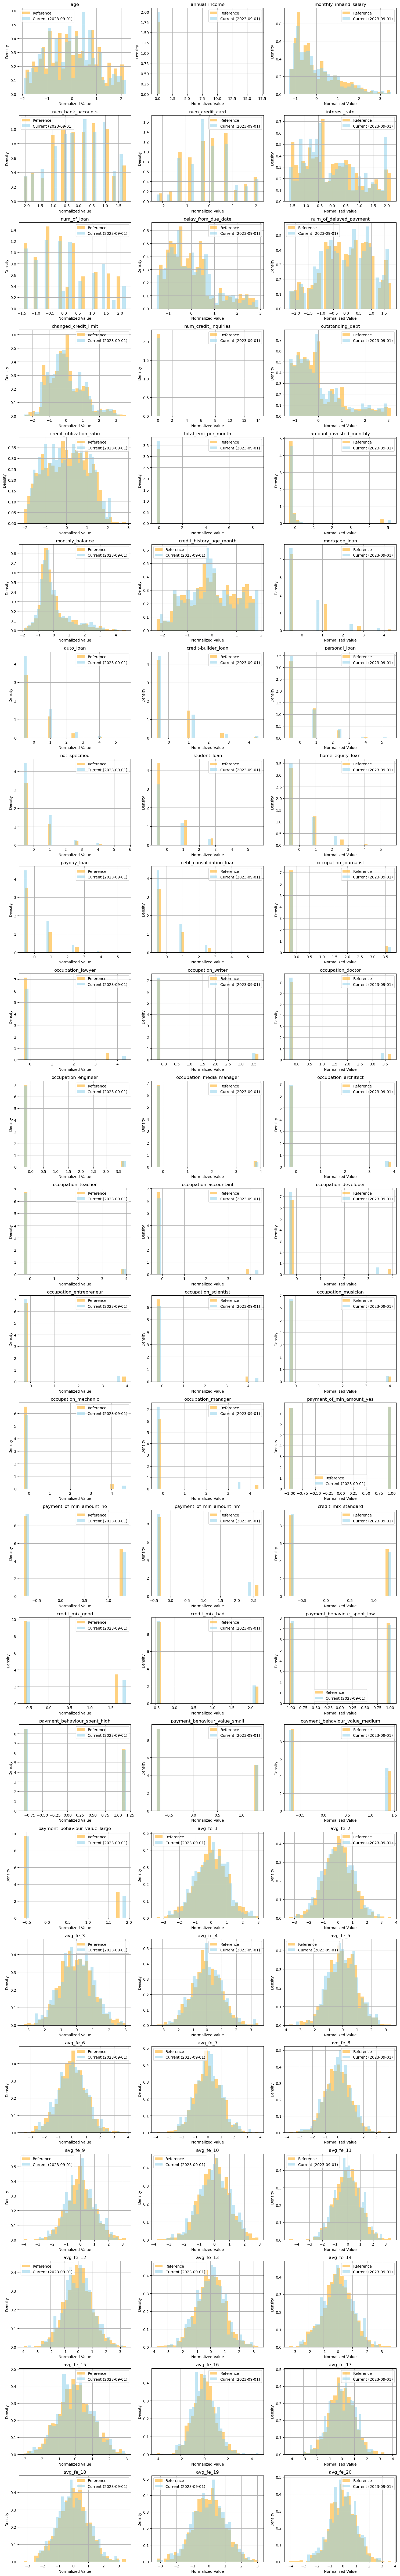

In [22]:
import matplotlib.pyplot as plt
import math

# Get latest and reference data
latest_date = pd.to_datetime('2023-09-01')
current_data = feature_store[feature_store['snapshot_date'] == latest_date]
reference_data = feature_store[feature_store['snapshot_date'] < latest_date]

# Get numeric features
numeric_cols = current_data.select_dtypes(include='number').columns.tolist()

# Normalize each feature (z-score normalization)
def normalize(series):
    return (series - series.mean()) / series.std()

# Grid layout
n_features = len(numeric_cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(numeric_cols):
    ax = axes[i]
    
    ref_vals = normalize(reference_data[feature].dropna())
    cur_vals = normalize(current_data[feature].dropna())

    ax.hist(ref_vals, bins=30, alpha=0.5, label='Reference', color='orange', density=True)
    ax.hist(cur_vals, bins=30, alpha=0.5, label=f'Current ({latest_date.date()})', color='skyblue', density=True)

    ax.set_title(f"{feature}")
    ax.set_xlabel("Normalized Value")
    ax.set_ylabel("Density")
    ax.grid(True)
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd

# Convert snapshot_date to datetime
feature_store['snapshot_date'] = pd.to_datetime(feature_store['snapshot_date'])

# Step 1: Define reference window
reference_data = feature_store[feature_store['snapshot_date'] < '2024-01-01']  # you can adjust this

# Step 2: Get list of target dates (after reference)
target_dates = pd.to_datetime(['2023-09-01','2023-10-01','2024-11-01']) #manual input
target_dates = [d for d in target_dates if d >= pd.to_datetime('2024-01-01')]
target_dates.sort()

# Step 3: Get numeric features
numeric_cols = feature_store.select_dtypes(include='number').columns.tolist()

# Step 4: Safe stats function
def safe_stats(series, z_thresh=5):
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    if series.empty:
        return np.nan, np.nan
    z_scores = (series - series.mean()) / series.std()
    filtered = series[np.abs(z_scores) < z_thresh]
    return filtered.mean(), filtered.std()

# Step 5: Loop through each date and compare to reference
drift_log = []

for date in target_dates:
    current_data = feature_store[feature_store['snapshot_date'] == date]
    
    for feature in numeric_cols:
        ref_vals = reference_data[feature].dropna()
        cur_vals = current_data[feature].dropna()

        ref_mean, ref_std = safe_stats(ref_vals)
        cur_mean, _ = safe_stats(cur_vals)

        if pd.notna(ref_std) and ref_std > 0:
            std_shift = abs(cur_mean - ref_mean) / ref_std
        else:
            std_shift = np.nan

        drift_log.append({
            'snapshot_date': date,
            'feature': feature,
            'ref_mean': ref_mean,
            'cur_mean': cur_mean,
            'ref_std': ref_std,
            'deviation': abs(cur_mean - ref_mean),
            'std_shift': std_shift
        })

# Step 6: Create drift DataFrame
drift_df = pd.DataFrame(drift_log)

# Optional: Filter to std_shift > 1
drifted_features = drift_df[drift_df['std_shift'] > 1].sort_values(['snapshot_date', 'std_shift'], ascending=[True, False])

# Show result
drifted_features.head()

,snapshot_date,feature,ref_mean,cur_mean,ref_std,deviation,std_shift
